In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import polars as pl
import os

DATASET_PATH = "/Users/victor/programming/random/zapcheck/Fake.br-Corpus"

schema = {
  "texto": pl.String,
  "label": pl.Int8
}

df = pl.DataFrame(schema=schema)

for file in os.listdir(os.path.join(DATASET_PATH, "full_texts/fake")):
  with open(os.path.join(DATASET_PATH, "full_texts/fake", file), "r") as f:
    df = df.vstack(pl.DataFrame({"texto": [f.read()], "label": [1]}, schema=schema))

for file in os.listdir(os.path.join(DATASET_PATH, "full_texts/true")):
  with open(os.path.join(DATASET_PATH, "full_texts/true", file), "r") as f:
    df = df.vstack(pl.DataFrame({"texto": [f.read()], "label": [0]}, schema=schema))

In [4]:
df.filter(df["label"] == 0).head()

texto,label
str,i8
"""‘É preciso ir além da Lava Jat…",0
"""Quem são os robôs assassinos, …",0
"""Corpo do jornalista Toninho Dr…",0
"""Moro ordena leilão público de …",0
"""Moro diz que discussão sobre p…",0


In [5]:
print("Dataset size: ", len(df))
print("true news: ", len(df.filter(df["label"] == 0)))
print("fake news: ", len(df.filter(df["label"] == 1)))


Tamanho do dataset:  7200
Quantidade de noticias verdadeiras:  3600
Quantidade de noticias falsas:  3600


In [6]:
print("Duplicados: ", df.is_duplicated().sum())

print("Nulos: ", df.null_count())

df = df.unique(maintain_order=True)

Duplicados:  2
Nulos:  shape: (1, 2)
┌───────┬───────┐
│ texto ┆ label │
│ ---   ┆ ---   │
│ u32   ┆ u32   │
╞═══════╪═══════╡
│ 0     ┆ 0     │
└───────┴───────┘


In [7]:
import spacy
import unicodedata

#uv run spacy download pt_core_news_sm

def remove_accents(input_str) -> str:
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.category(c) == 'Mn'])

df = df.with_columns(
  texto=pl.col("texto")
    .str.to_lowercase()
    .str.replace_all(r'https?://\S+', '')
    .str.replace_all(r'[^a-zA-Z0-9\s]', '')
    .map_elements(remove_accents, return_dtype=pl.Utf8)
    .str.replace_all(r'\s+', ' ')
)

#remove stopwords
nlp = spacy.load("pt_core_news_sm")

def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if not token.is_stop])

df = df.with_columns(
  texto=pl.col("texto").map_elements(remove_stopwords, return_dtype=pl.Utf8)
)

df.head()

texto,label
str,i8
"""new york times foratarefa comb…",1
"""recuperao apstolo valdemiro sa…",1
"""cargueiro venezuelano pouso fo…",1
"""lavajato investiga apto presid…",1
"""vdeo lula ataca pf judicirio c…",1


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tf-idf: TF - frequencia de termo, IDF - frequencia inversa de documento
def tfidf(df, max_features=5000, min_df=5, max_df=0.8):
  vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df)
  X_tfidf = vectorizer.fit_transform(df["texto"].to_list())

  feature_names = vectorizer.get_feature_names_out()
  df_tfidf = pl.DataFrame(X_tfidf.toarray(), schema=list(feature_names))

  return df_tfidf.with_columns([
    pl.Series("label", df["label"])
  ])

df_final = tfidf(df)

In [74]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# best_tree = None
# best_accuracy = 0

# for max_depth in max_depths:
#   for min_samples_split in min_samples_splits:
#     for min_samples_leaf in min_samples_leaves:

#       model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=777)
#       model.fit(X_train, y_train)

#       y_pred = model.predict(X_test)
#       accuracy = accuracy_score(y_test, y_pred)
#       print(f"Max Depth: {max_depth}, Min Samples Split: {min_samples_split}, Min Samples Leaf: {min_samples_leaf}, Acc: {accuracy}")

#       if accuracy > best_accuracy:
#         best_accuracy = accuracy
#         best_tree = model

df_pandas = df_final.to_pandas()

X = df_pandas.drop(columns=["label"])
y = df_pandas["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

DTC = DecisionTreeClassifier(random_state=777)
path = DTC.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[1:]
sampled_alphas = np.linspace(ccp_alphas.min(), ccp_alphas.max(), num=5)

print(sampled_alphas)

params = { 
    'max_depth': [10, 15, 20],
    'min_samples_split': [10,20,35,50],
    'min_samples_leaf': [5,10,15,20],
    "ccp_alpha": sampled_alphas
}


grid = GridSearchCV(
    DecisionTreeClassifier(random_state=77),
    param_grid=params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)
print("Best Params:", grid.best_params_)
print("Best Score:", grid.best_score_)

[0.00023152 0.03090823 0.06158493 0.09226163 0.12293834]
Fitting 5 folds for each of 240 candidates, totalling 1200 fits


KeyboardInterrupt: 

In [67]:
model = grid.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

model.fit(X_train, y_train)

print(f"Train Accuracy: {model.score(X_train, y_train):.2f}")
print(f"Test Accuracy: {model.score(X_test, y_test):.2f}")

y_pred = model.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test, digits=3))

Train Accuracy: 0.91
Test Accuracy: 0.89
              precision    recall  f1-score   support

           0      0.888     0.891     0.889       731
           1      0.887     0.884     0.886       709

    accuracy                          0.887      1440
   macro avg      0.887     0.887     0.887      1440
weighted avg      0.887     0.887     0.887      1440



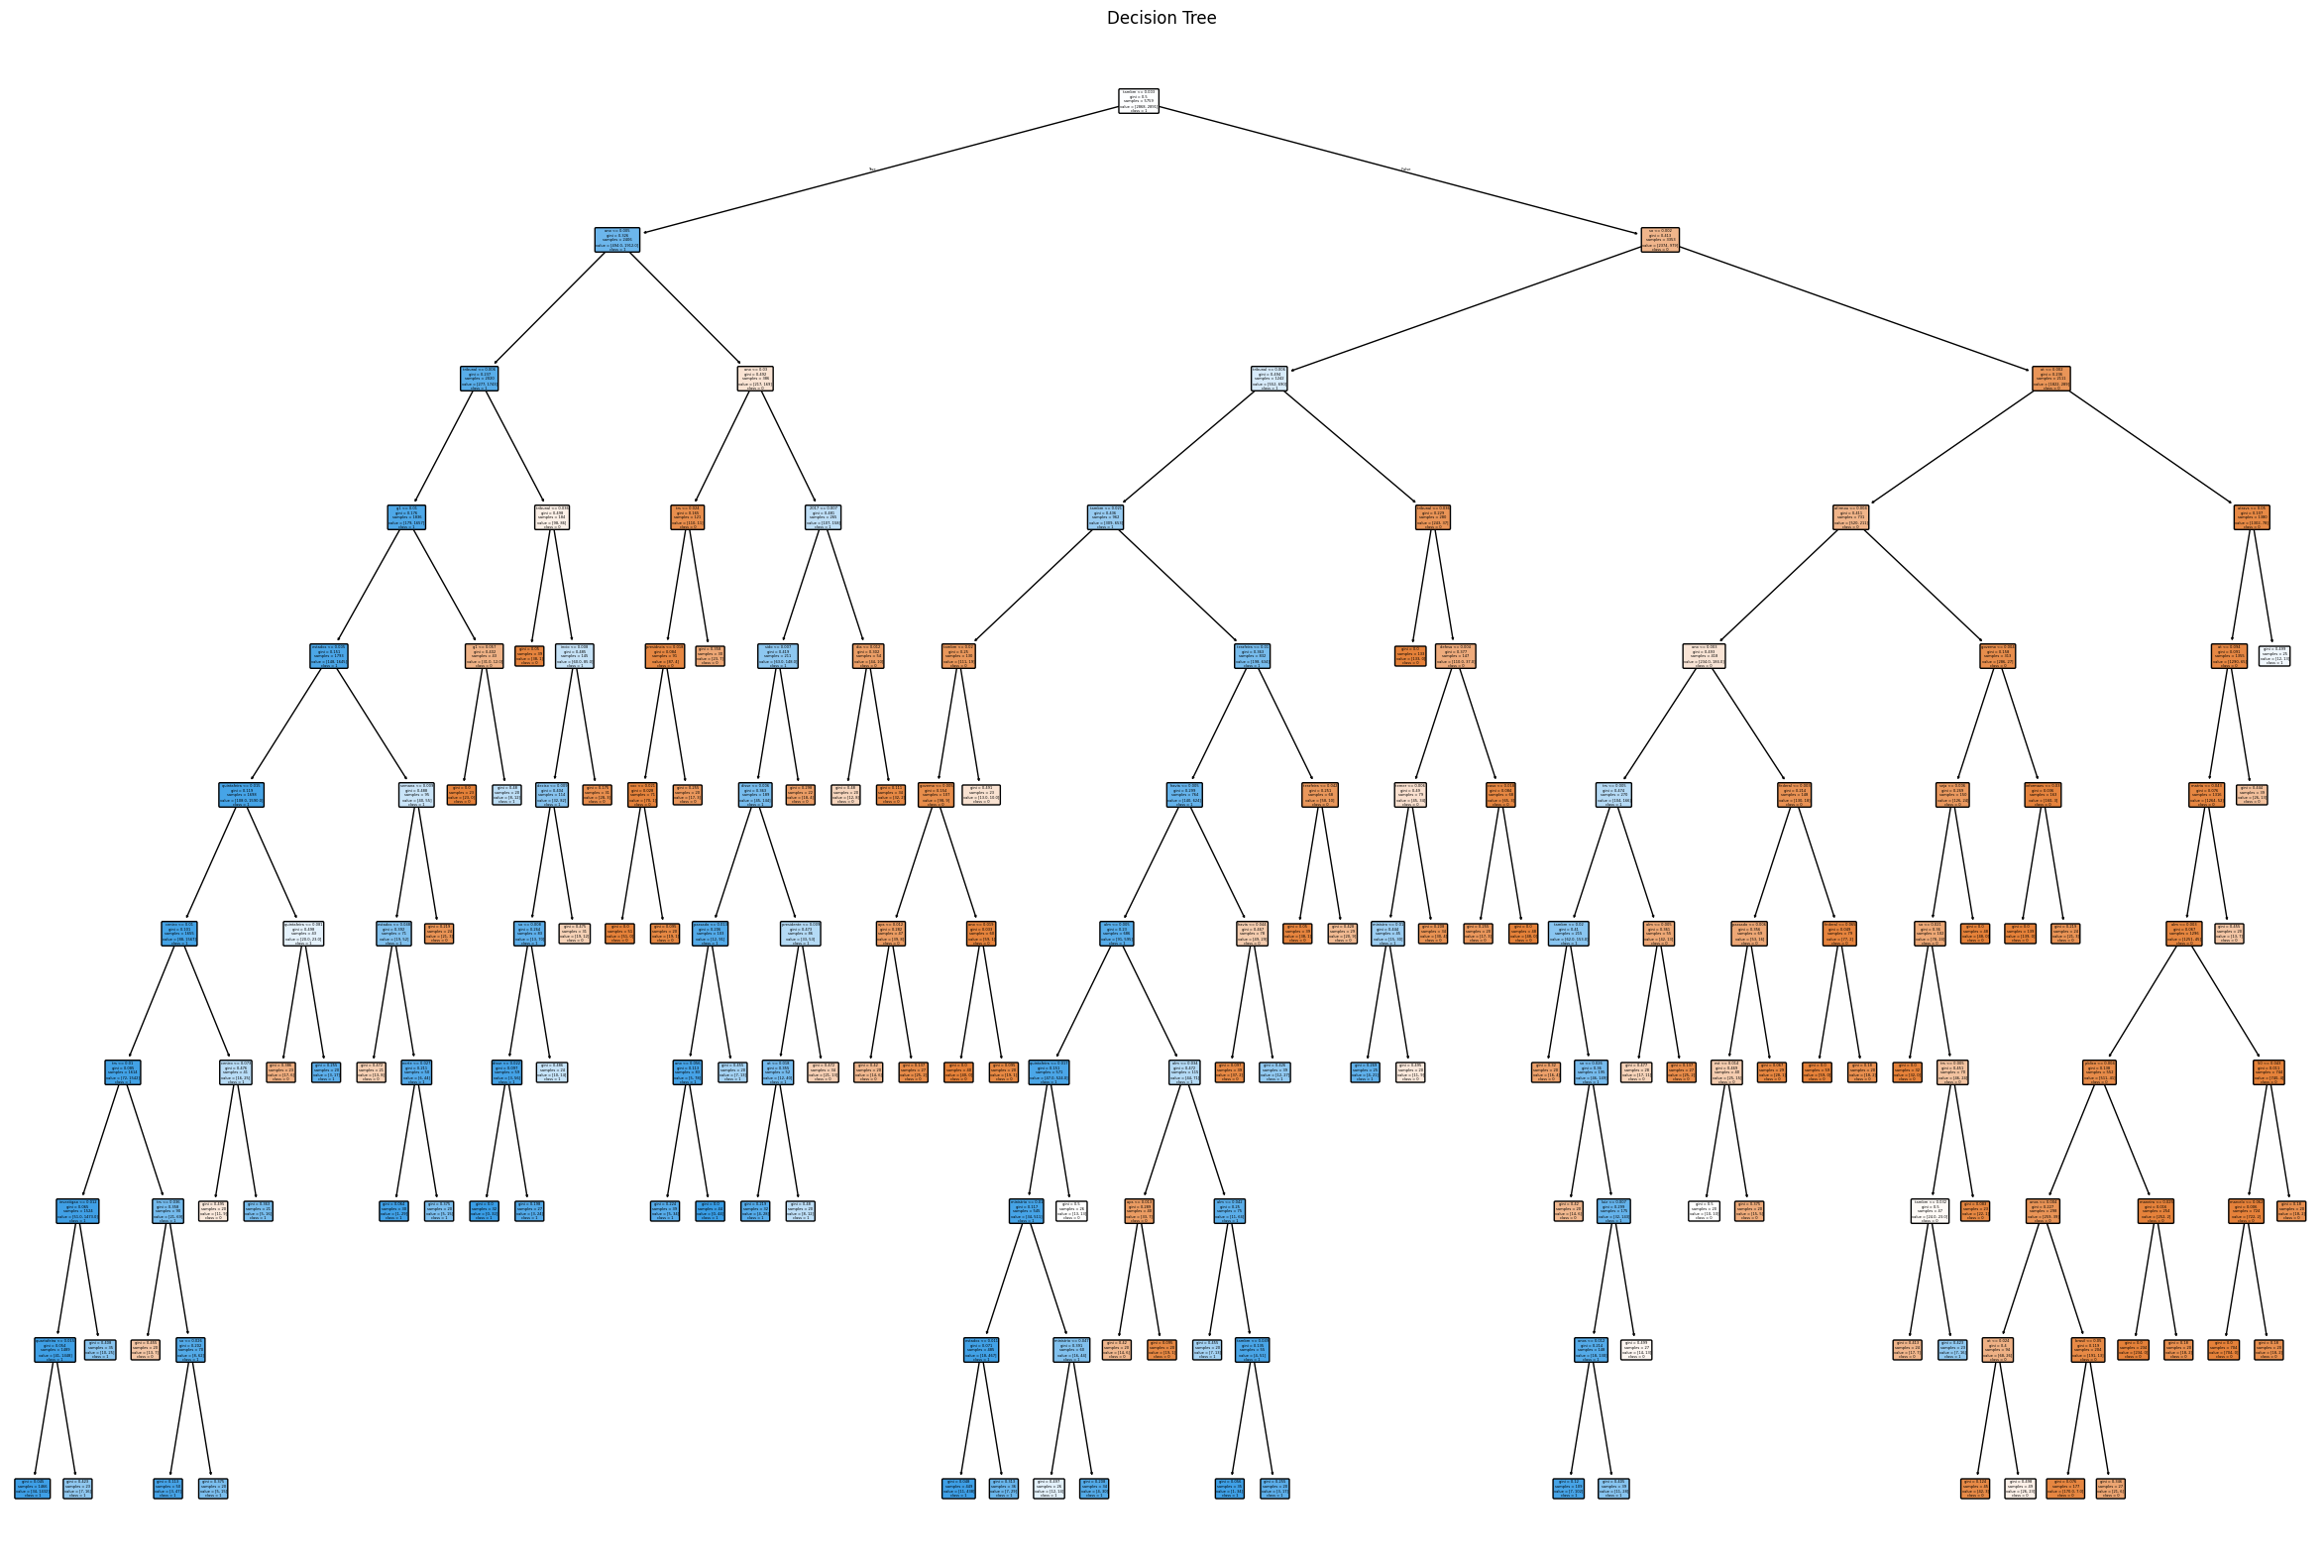

In [69]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))

plot_tree(
    model, 
    feature_names=X.columns,
    class_names=[str(c) for c in model.classes_],
    filled=True,
    rounded=True,
    max_depth=20
)

plt.title("Decision Tree")
plt.show()
